In [26]:
import tensorflow as tf 
from tensorflow import keras 
import matplotlib.pyplot as plt 
import numpy as np 
import os 

import zipfile 
from PIL import Image

# Pre-trained models and transfer learning

In [7]:
physical_devices = tf.config.list_physical_devices("GPU")
if len(physical_devices)>0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("work in GPU")
else: 
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # CPU
    print("work in CPU")

work in CPU


## Data

In [8]:
!wget -P data -q https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

In [12]:
with zipfile.ZipFile("./data/kagglecatsanddogs_5340.zip", "r") as zip_ref:
    zip_ref.extractall("data")

cleaning data

In [37]:
def rm_corrupted(path, clas):    
    filenames = os.listdir(path + clas)
    print("total images : ", len(filenames))
    count = 0
    for filename in filenames:
        try:
            img = Image.open(path + clas + filename)
            img.verify()
        except (IOError, SyntaxError) as e:
            #print("bad file : ", filename)
            os.remove(path + clas + filename)
            count += 1
    print("# errors : ", count)
    print("    %    : ", round(float(count/len(filenames)),4))

In [40]:
rm_corrupted("./data/PetImages/", "Dog/")

total images :  12499


/home/angel/Documents/galois1915/Computer-vision/.env/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:868: UserWarning: Truncated File Read
  warnings.warn(str(msg))


# errors :  0
    %    :  0.0


In [39]:
rm_corrupted("./data/PetImages/", "Cat/")

total images :  12501
# errors :  2
    %    :  0.0002


## Loading the data

In [41]:
data_dir = 'data/PetImages'
batch_size = 32

ds_train = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 13,
    image_size = (224,224),
    batch_size = batch_size
)
ds_test = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 13,
    image_size = (224,224),
    batch_size = batch_size
)

Found 24998 files belonging to 2 classes.
Using 19999 files for training.
Found 24998 files belonging to 2 classes.
Using 4999 files for validation.


In [42]:
ds_train.class_names

['Cat', 'Dog']

In [46]:
for x,y in ds_train:
    print(f"Training batch shape: features={x.shape}, labels={y.shape}")
    x_sample, y_sample = x,y
    break

Training batch shape: features=(32, 224, 224, 3), labels=(32,)


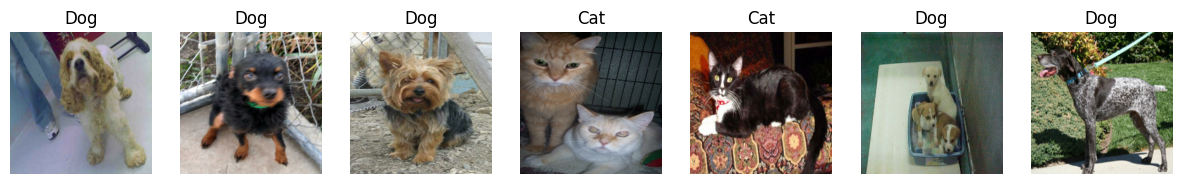

In [75]:
fig,ax = plt.subplots(ncols=7, nrows=1, figsize=(15,3))
classes = ["Cat", "Dog"]
for i in range(7):
    ax[i].imshow(x_sample[i].numpy()/255.0)
    ax[i].set_title(classes[y_sample[i].numpy()])
    ax[i].axis('off')

## Pre-trained models

There are many pre-trained neural networks for image classification. Many of those models are available inside the keras.applications namespace, and even more models can be found on the Internet. Let's see how the simplest pre-trained model (VGG-16) can be loaded and used

### VGG model

In [ ]:
# Download model weights in the sandbox environment
#!mkdir -p ~/.keras/models
#!wget -P ~/.keras/models -q https://mslearntensorflowlp.blob.core.windows.net/models/vgg16_weights_tf_dim_ordering_tf_kernels.h5
#!wget -P ~/.keras/models -q https://mslearntensorflowlp.blob.core.windows.net/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
#!wget -P ~/.keras/models -q https://mslearntensorflowlp.blob.core.windows.net/models/imagenet_class_index.json

In [76]:
vgg = tf.keras.applications.VGG16()

2023-12-27 16:39:58.854175: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2023-12-27 16:39:59.075929: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2023-12-27 16:39:59.157520: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


553467096/553467096 [==============================] - 286s 1us/step


2023-12-27 16:44:47.900389: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


In [81]:
x_sample[:1].shape

TensorShape([1, 224, 224, 3])

In [ ]:
#tf.keras.applications.vgg16.VGG16(
#    include_top=True,
#    weights='imagenet',
#    input_tensor=None,
#    input_shape=None,
#    pooling=None,
#    classes=1000,
#    classifier_activation='softmax'
#)

In [82]:
inp = keras.applications.vgg16.preprocess_input(x_sample[:1])

res = vgg(inp)
print(f"Most probable class = {tf.argmax(res,1)}")

keras.applications.vgg16.decode_predictions(res.numpy())

Most probable class = [219]
35363/35363 [==============================] - 0s 6us/step


[[('n02102318', 'cocker_spaniel', 0.6209866),
  ('n02101556', 'clumber', 0.2695338),
  ('n02102480', 'Sussex_spaniel', 0.06074093),
  ('n02086646', 'Blenheim_spaniel', 0.015620461),
  ('n02102177', 'Welsh_springer_spaniel', 0.013352634)]]

There are a couple of important things here:
* Before passing an input to any pre-trained network it has to be pre-processed in a certain way. This is done by calling corresponding `preprocess_input` function, which receives a batch of images, and returns their processed form. In the case of VGG-16, images are normalized, and some pre-defined average value for each channels is subtracted. That is because VGG-16 was originally trained with this pre-processing.
* Neural network is applied to the input batch, and we receive as the result a batch of 1000-element tensors that show probability of each class. We can find the most probable class number by calling `argmax` on this tensor.
* Obtained result is a [number of an `ImageNet` class](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). To make sense of this result, we can also use `decode_predictions` function, that returns top n classes together with their names.

In [85]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Extracting features

In [86]:
vgg = keras.applications.VGG16(include_top=False)

inp = keras.applications.vgg16.preprocess_input(x_sample[:1])
res = vgg(inp)

58889256/58889256 [==============================] - 29s 0us/step


In [87]:
res.shape

TensorShape([1, 7, 7, 512])

In [91]:
ds_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [92]:
num = batch_size*25
ds_features_train = ds_train.take(25).map(lambda x,y : (vgg(x),y))
ds_features_test = ds_test.take(10).map(lambda x,y : (vgg(x),y))

for x,y in ds_features_train:
    print(x.shape,y.shape)
    break

2023-12-27 17:02:25.662572: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


(32, 7, 7, 512) (32,)


### Add layer classifier

In [95]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(7,7,512)),
    keras.layers.Dense(1,activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
hist = model.fit(ds_features_train, validation_data=ds_features_test)

 5/25 [=====>........................] - ETA: 6:21 - loss: 4.2121 - acc: 0.6812

25/25 [==============================] - 674s 27s/step - loss: 1.7411 - acc: 0.8800 - val_loss: 1.1670 - val_acc: 0.9500


### Transfer learning using VGG

In [96]:
model = keras.models.Sequential()
model.add(keras.applications.VGG16(include_top=False,input_shape=(224,224,3)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1,activation='sigmoid'))

model.layers[0].trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 14739777 (56.23 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [97]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
hist = model.fit(ds_train.take(50), validation_data=ds_test.take(10))

 3/50 [>.............................] - ETA: 4:47 - loss: 7.2897 - acc: 0.4583

50/50 [==============================] - 374s 7s/step - loss: 1.5775 - acc: 0.9019 - val_loss: 1.6575 - val_acc: 0.9312


### Saving and Loading the model

In [98]:
model.save('data/FineTuned_TensorFlow.tf')

INFO:tensorflow:Assets written to: data/FineTuned_TensorFlow.tf/assets


INFO:tensorflow:Assets written to: data/FineTuned_TensorFlow.tf/assets


In [100]:
model = keras.models.load_model('data/FineTuned_TensorFlow.tf')